# Clustering using TF-IDF + KMeans

The main goal of this notebook is to extract vectors from the documents. Then apply a clustering algorithm (KMeans) to this vectors to extract clusters. Finally, compare thos clusters with the "true" classes.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

# -- Data

In [96]:
N_CLUSTERS = 5

In [97]:
bbc_news_df = pd.read_csv('../../datasets/BBC_News/dataset.csv')

train_df = bbc_news_df[bbc_news_df['dataset_type'] == 'train'].copy()
test_df = bbc_news_df[bbc_news_df['dataset_type'] == 'test'].copy()

bbc_news_df.head()

,document,class_name,class_index,dataset_type
0,hit shelf combine medium player phone gaming g...,tech,1,train
1,bid hope join host apply host tournament aim r...,sport,4,train
2,lord wrong detainee straw straw attack decisio...,politics,3,train
3,leak answer minister explain budget detail pri...,politics,3,train
4,delight manager pay tribute goal striker beat ...,sport,4,train


# -- Training TfidfVectorizer and KMeans

In [98]:
def train():
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_train = tfidf_vectorizer.fit_transform(train_df['document'])

    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    kmeans.fit(tfidf_train)
    return kmeans, tfidf_vectorizer

kmeans_model, tfidf_vectorizer_model = train()

def get_tfidf(df: pd.DataFrame):
    return tfidf_vectorizer_model.transform(df['document'])

def get_cluster(df:  pd.DataFrame):
    return kmeans_model.predict(tfidf_vectorizer_model.transform(df['document']))

# -- Link between clusters and classes

To compare clusters from true classes, we compute the centroid of a dimensional set of points for the clusters and the classes. So that we can associate each cluster to its nearest class.

> **Problem:** 
>
> To find the centroid of the classes, we need to have points associated with each class -> Supervised! So clustering can be used to find clusters, but this method cannot be used to associated clusters to classes.

> **Question:**
>
> How to associate clusters to the true wanted classes (if provided) ?

In [99]:
def compute_centroid_of_set_points(points: tuple):
    return tuple(map(lambda x: sum(x) / len(x), zip(*points)))

def distance_between_points(p1: tuple, p2: tuple):
    return sum(map(lambda x: (x[0] - x[1]) ** 2, zip(p1, p2))) ** 0.5

In [109]:
def plot_classes_and_clusters(df):
    n_classes = len(bbc_news_df['class_index'].unique())
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'[{df.iloc[0]["dataset_type"].upper()}] Classes and their assigned clusters', fontweight='bold', fontsize=16)
    fig.tight_layout(pad=4.0, rect=[0, 0.03, 1, 1.06])

    x, y = 0, 0

    tfidf_vectors = get_tfidf(df)
    clusters = get_cluster(df)

    pca = PCA(n_components=2)
    base_features = tfidf_vectors.toarray()
    reduced_features = pca.fit_transform(base_features)

    for class_idx in range(n_classes):
        class_points = base_features[df['class_index'] == class_idx]
        class_centroid = compute_centroid_of_set_points(class_points)
        
        nearest_cluster = None
        nearest_cluster_distance = None

        for cluster_idx in range(N_CLUSTERS):
            cluster_points = base_features[clusters == cluster_idx]
            cluster_centroid = compute_centroid_of_set_points(cluster_points)
            distance = distance_between_points(class_centroid, cluster_centroid)

            if nearest_cluster_distance is None or distance < nearest_cluster_distance:
                nearest_cluster = cluster_idx
                nearest_cluster_distance = distance

        reduced_class_points = reduced_features[df['class_index'] == class_idx]
        reduced_nearest_cluster_points = reduced_features[clusters == nearest_cluster]

        reduced_nearest_cluster_centroid = compute_centroid_of_set_points(reduced_nearest_cluster_points)
        reduced_class_centroid = compute_centroid_of_set_points(reduced_class_points)

        sns.kdeplot(x=reduced_class_points[:, 0], y=reduced_class_points[:, 1], ax=ax[x, y], fill=True, alpha=0.5, legend=False)
        sns.scatterplot(x=[reduced_nearest_cluster_centroid[0]], y=[reduced_nearest_cluster_centroid[1]], ax=ax[x, y], color='orange', s=50, legend=False, label=f'Centroid cluster {nearest_cluster}')

        sns.kdeplot(x=reduced_nearest_cluster_points[:, 0], y=reduced_nearest_cluster_points[:, 1], ax=ax[x, y], fill=True, alpha=0.5, legend=False)
        sns.scatterplot(x=[reduced_class_centroid[0]], y=[reduced_class_centroid[1]], ax=ax[x, y], color='blue', s=50, legend=False, label=f'Centroid class {class_idx}')

        ax[x, y].set_title(f'Class {class_idx} <=> Cluster {nearest_cluster}')
        ax[x, y].set_xlim(-0.5, 0.5)
        ax[x, y].set_ylim(-0.5, 0.5)
        ax[x, y].set_xlabel('PC1')
        ax[x, y].set_ylabel('PC2')
        ax[x, y].legend(loc='upper right')

        if y == 2:
            x += 1
            y = 0
        else:
            y += 1

    sns.kdeplot(x=reduced_features[:, 0], y=reduced_features[:, 1], ax=ax[x, y], fill=True, alpha=0.5, hue=clusters, legend=True, palette='tab10')
    ax[x, y].set_title('All clusters')

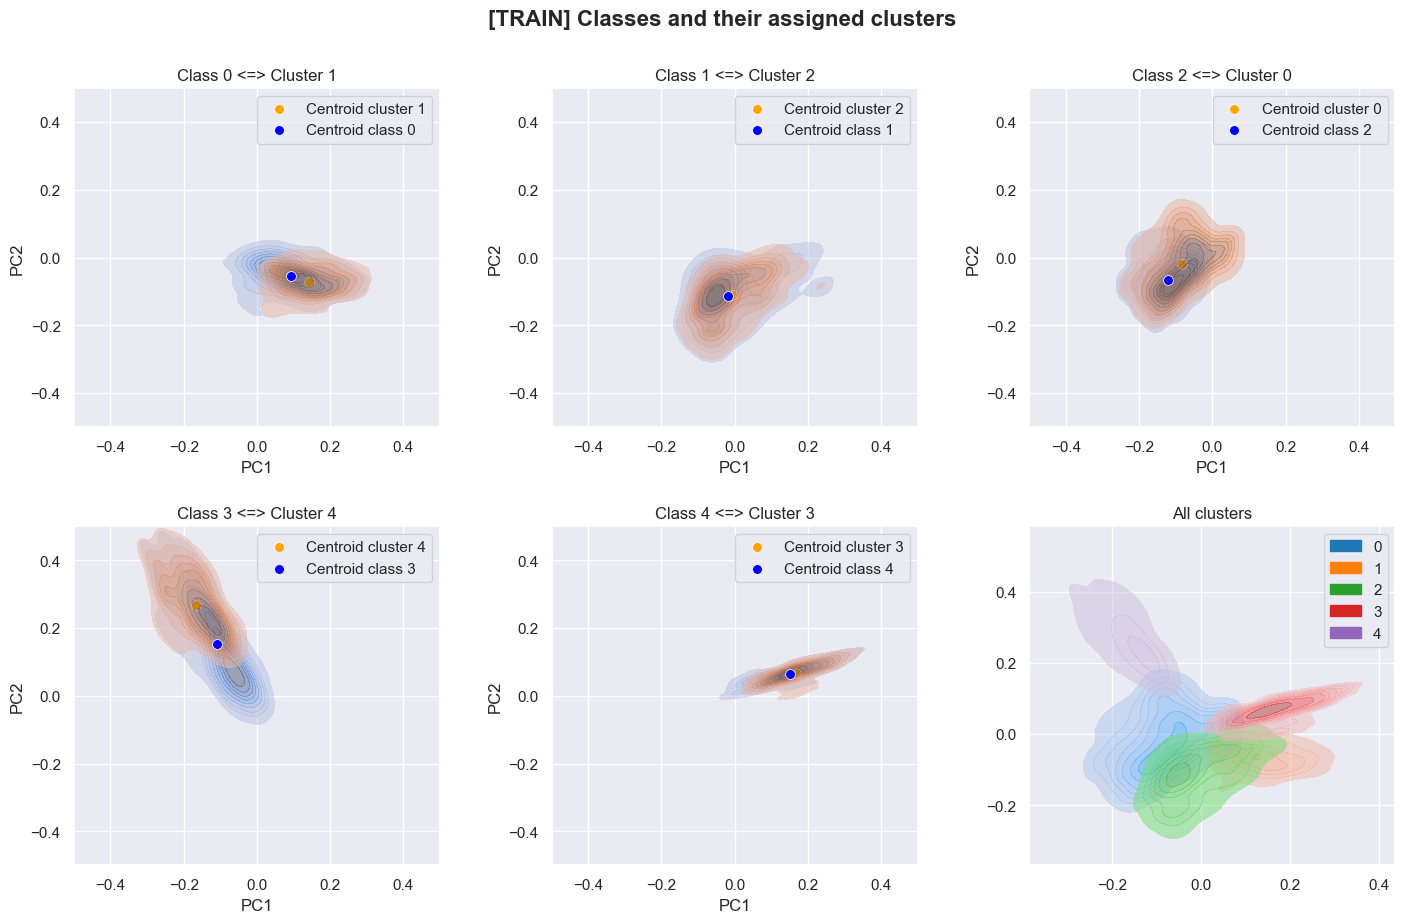

In [110]:
plot_classes_and_clusters(train_df)

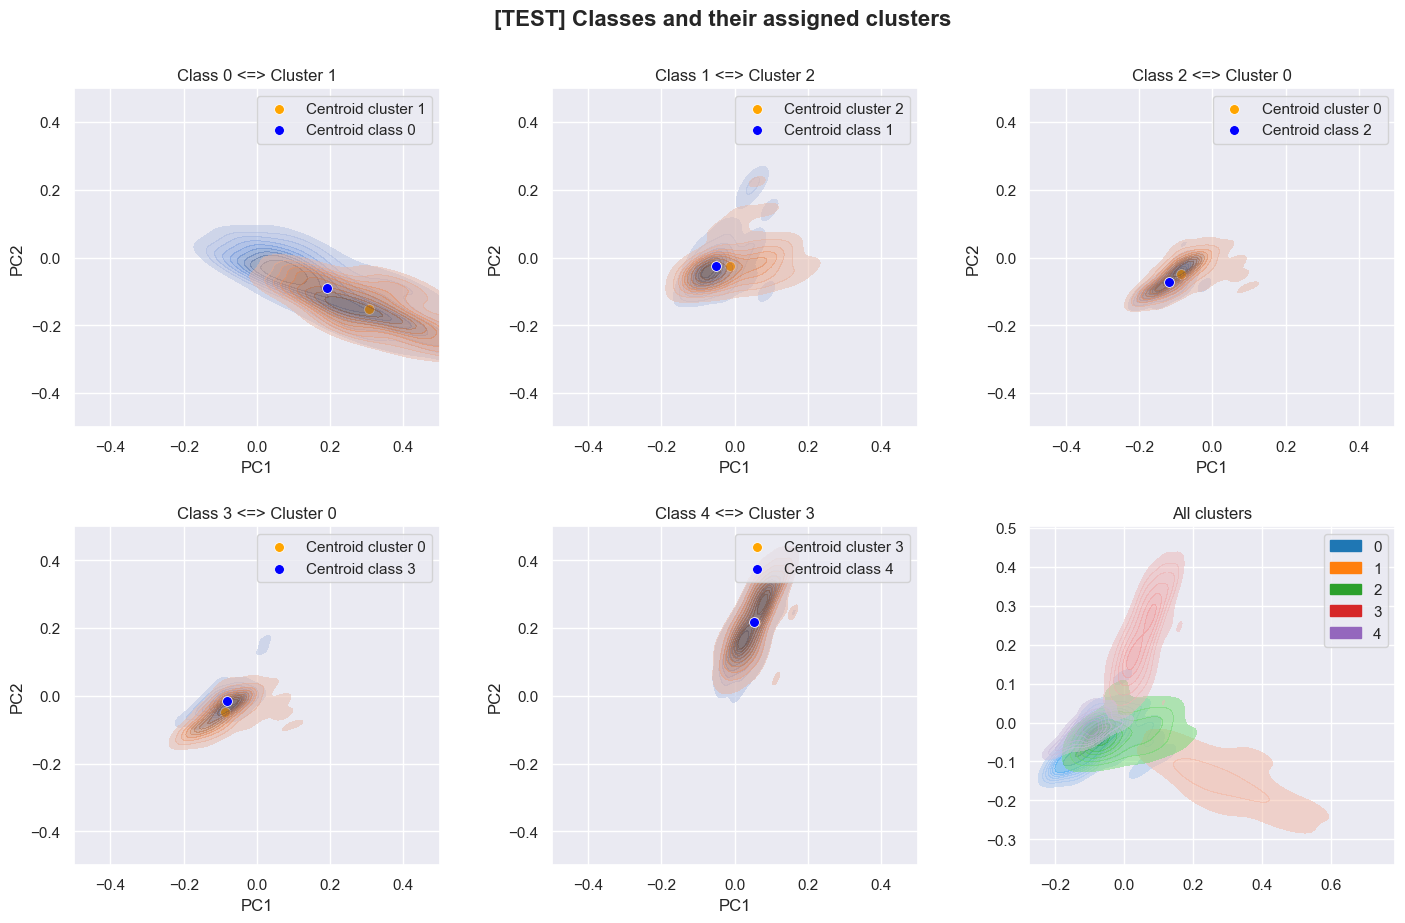

In [111]:
plot_classes_and_clusters(test_df)

We can see that indeed clusters matches approximately classes but in 2D.

> **Question:**
>
> Is it a problem in high dimensions?

-- Scores of this association

In [112]:
association_clusters_classes = {
    0: 2, # Cluster 0 <=> Class 2
    1: 0, # Cluster 1 <=> Class 0
    2: 1, # Cluster 2 <=> Class 1
    3: 4, # Cluster 3 <=> Class 4
    4: 3  # Cluster 4 <=> Class 3
}

y_pred_train = [association_clusters_classes[c] for c in kmeans_model.predict(get_tfidf(train_df))]
y_true_train = train_df['class_index']

y_pred_test = [association_clusters_classes[c] for c in kmeans_model.predict(get_tfidf(test_df))]
y_true_test = test_df['class_index']

print(f'F1 score for train: {f1_score(y_true_train, y_pred_train, average="macro")}')
print(f'F1 score for test: {f1_score(y_true_test, y_pred_test, average="macro")}')

F1 score for train: 0.7429450666984666
F1 score for test: 0.72176861726442


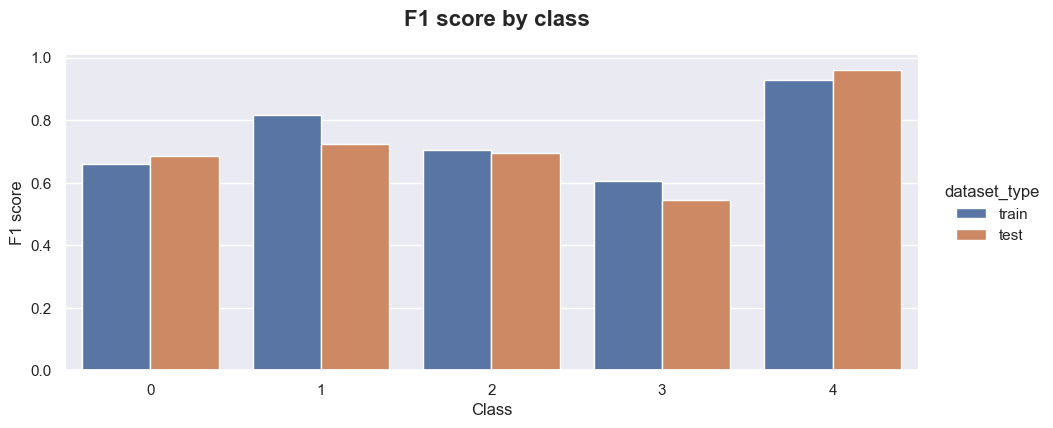

In [113]:
# F1 score by class
f1_scores_train = f1_score(y_true_train, y_pred_train, average=None)
f1_scores_test = f1_score(y_true_test, y_pred_test, average=None)

f1_scores_df = pd.DataFrame({'train': f1_scores_train, 'test': f1_scores_test})
f1_scores_df['class'] = f1_scores_df.index
f1_scores_df = f1_scores_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

fig = sns.catplot(data=f1_scores_df, x='class', y='f1_score', hue='dataset_type', kind='bar', height=5, aspect=2)
fig.set(xlabel='Class', ylabel='F1 score')
fig.fig.suptitle('F1 score by class', fontweight='bold', fontsize=16)
fig.tight_layout(pad=4.0, rect=[0, 0.03, 0.94, 1.2])

# -- Focus on specific link (Class 0 with Cluster 2)

This section will try to answer the following question.

> **Question:**
>
> Is there a way to associate a class to a cluster with fewer knowledge ? (For example, some keywords or a few documents)

## Test with a few documents (Semi-supervised)

In [123]:
FOCUSED_CLASS = 0
FOCUSED_CLUSTER = 1

In [124]:
def get_class_point_with_dataset():
    tfidf_vectors = get_tfidf(bbc_news_df)

    pca = PCA(n_components=2)
    base_features = tfidf_vectors.toarray()
    reduced_features = pca.fit_transform(base_features)

    return reduced_features[bbc_news_df['class_index'] == FOCUSED_CLASS]

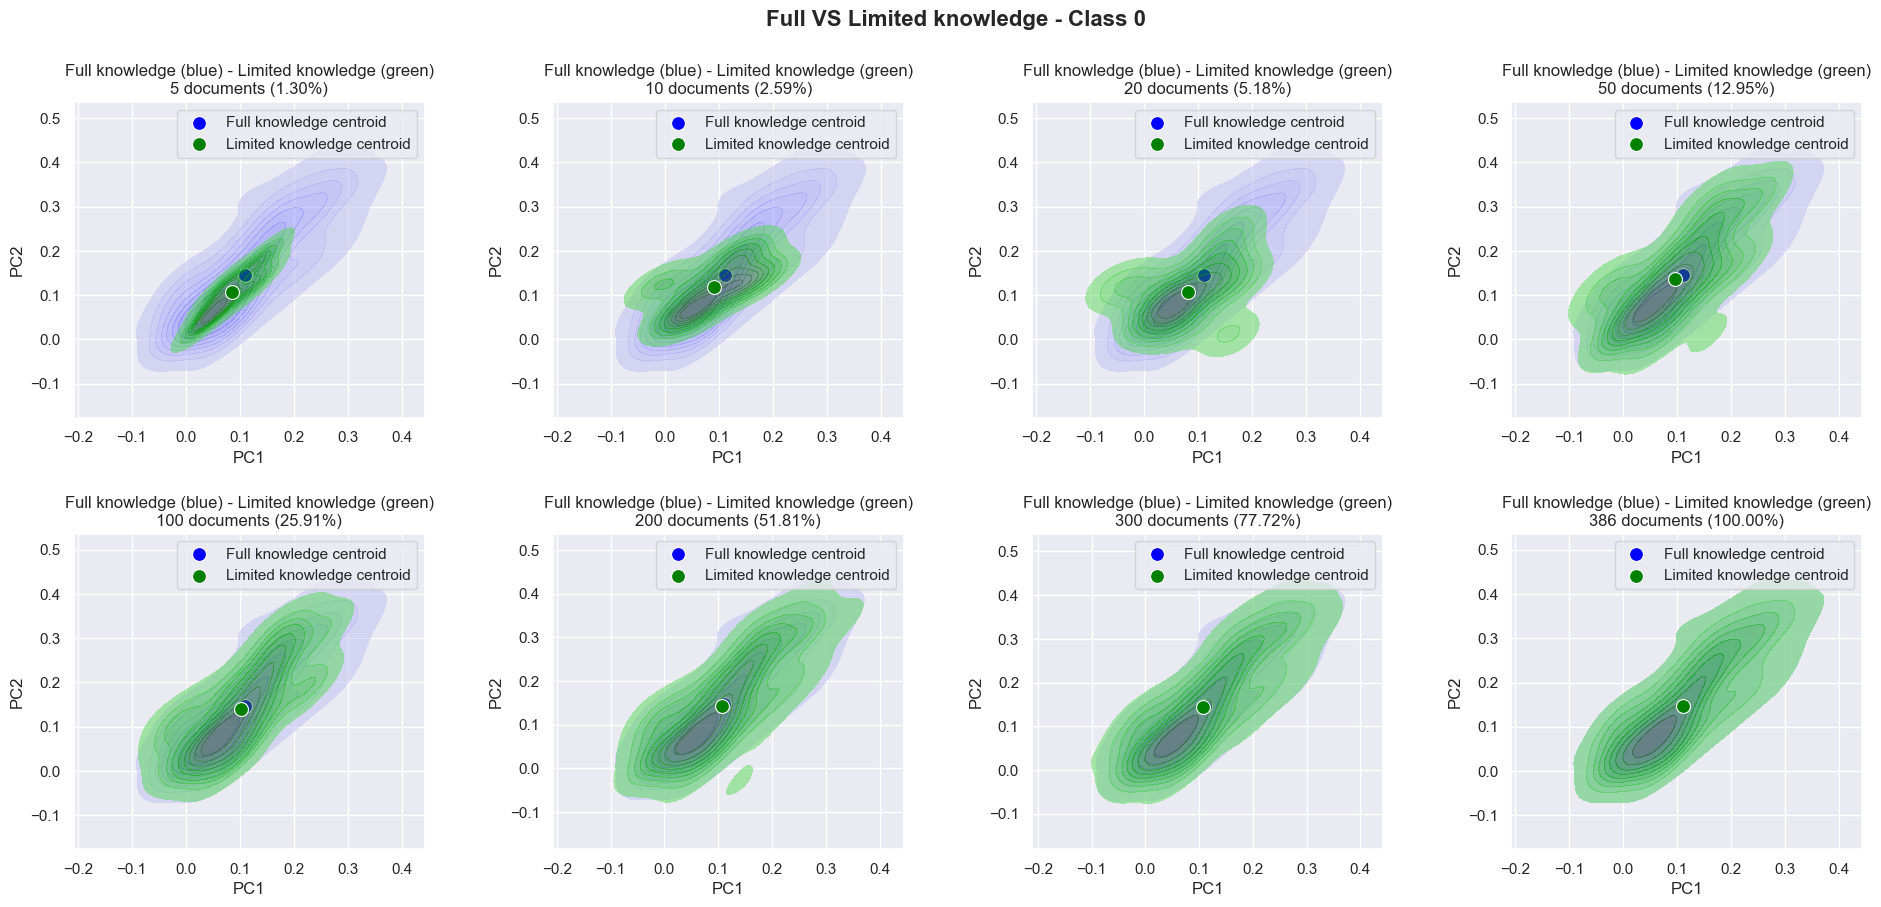

In [132]:
full_knowledge_class_points = get_class_point_with_dataset()
full_knowledge_centroid = compute_centroid_of_set_points(full_knowledge_class_points)

n_known_documents_range = [5, 10, 20, 50, 100, 200, 300, 400]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'Full VS Limited knowledge - Class {FOCUSED_CLASS}', fontweight='bold', fontsize=16)
fig.tight_layout(pad=5.0, rect=[0, 0.03, 1, 1.08])

x, y = 0, 0

for i, n_known_documents in enumerate(n_known_documents_range):
    limited_knowledge_class_points = get_class_point_with_dataset()
    limited_knowledge_class_points = limited_knowledge_class_points[:n_known_documents]
    limited_knowledge_centroid = compute_centroid_of_set_points(limited_knowledge_class_points)

    sns.kdeplot(x=full_knowledge_class_points[:, 0], y=full_knowledge_class_points[:, 1], ax=ax[x, y], fill=True, alpha=0.5, color='blue')
    sns.scatterplot(x=[full_knowledge_centroid[0]], y=[full_knowledge_centroid[1]], ax=ax[x, y], color='blue', s=100, label='Full knowledge centroid')

    sns.kdeplot(x=limited_knowledge_class_points[:, 0], y=limited_knowledge_class_points[:, 1], ax=ax[x, y], fill=True, alpha=0.5, color='green')
    sns.scatterplot(x=[limited_knowledge_centroid[0]], y=[limited_knowledge_centroid[1]], ax=ax[x, y], color='green', s=100, label='Limited knowledge centroid')
    
    ax[x, y].set_title(f'Full knowledge (blue) - Limited knowledge (green)\n{len(limited_knowledge_class_points)} documents ({len(limited_knowledge_class_points) / len(full_knowledge_class_points) * 100:.2f}%)')
    ax[x, y].set_xlabel('PC1')
    ax[x, y].set_ylabel('PC2')

    if y == 3:
        x += 1
        y = 0
    else:
        y += 1

> **Problem:**
>
> - Semi-supervised =/= Unsupervised
> - Still need more or less 20 documents PER CLASS to be close to the centroid using supervised method